# 유효한 비디오 추출 과정

먼저, 공개한 웹사이트에서 COMS에 관한 모든 이미지를 다운받아 *data* 폴더에 저장합니다.

해당 폴더는 다음과 같이 구성되어야합니다.

"{년도}{월}/{일}/{이미지 이름}" e.g. 202111/01/...

여기서, COMS 위성에서 찍은 이미지들을 가지고 다음 과정을 보여주고자 합니다.

1. 유효한 이미지를 뽑아내기: 이미지 하나를 (4=전체 채널 개수, 이미지 높이, 이미지 너비)로 보아, 동시대에 4개의 다른 채널에서 찍힌 이미지가 존재할 경우만 고려합니다.

2. 관측 주기를 분석하기: 시간순으로 정렬된 이미지들 간의 시간 차이를 분석합니다.

3. 6시간 길이의 비디오를 구성할 이미지는 몇 장 정도인 지 분석하기: 관측된 모든 유효한 이미지를 기준으로 6시간 동안 찍힌 이미지의 개수를 분석합니다.

In [1]:
import os
from collections import defaultdict
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import random
from skimage.measure import block_reduce
import numpy as np
from PIL import Image
from skimage.io import imread, imsave

In [2]:
data_directory = '/data1/'

1. 유효한 이미지 (4=전체 채널 개수, 이미지 높이, 이미지 너비) 추출

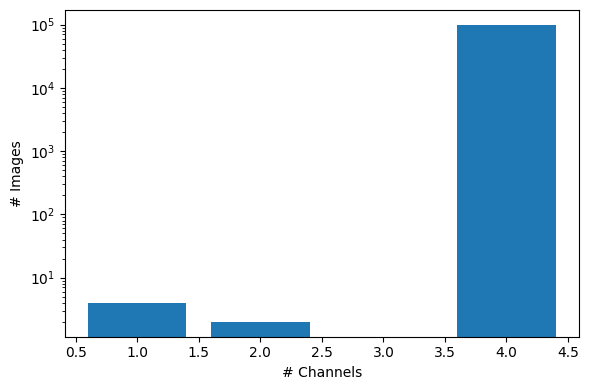

In [3]:
datetime2images = defaultdict(dict)
month2days = [-1, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

for year in [2010, 2011, 2012, 2013, 2014]:
    for month in range(1, 12+1):
        for day in range(1, 31+1):            
            if (year == 2010) and (month < 9):
                continue           
            if (month2days[month] < day) or (month == 2 and year % 4 and day > 28):
                continue
            
            directory = data_directory + '{}{:02d}/{:02d}'.format(year, month, day)
            if os.path.isdir(directory):
                file_list = os.listdir(directory)
                file_cnt = 0
                for f in file_list:
                    satellite, _, _, sensor, v, date = f.split('.')[0].split('_')
                    if v != 'ea040ps':
                        continue
                    datetime2images[date][sensor] = f
                    
valid_datetime = []
numchannel_per_img = defaultdict(int)
for d in datetime2images:
    numchannel_per_img[len(datetime2images[d].keys())] += 1
    if len((datetime2images[d].keys())) == 4:
        valid_datetime.append(d)
valid_datetime = sorted(valid_datetime)

plt.figure(dpi=100)
plt.bar(numchannel_per_img.keys(), numchannel_per_img.values())
plt.yscale('log')
plt.xlabel("# Channels")
plt.ylabel("# Images")
plt.tight_layout()
plt.show()

2. 관측 주기 분석

86% images have  15.0  minute time interval


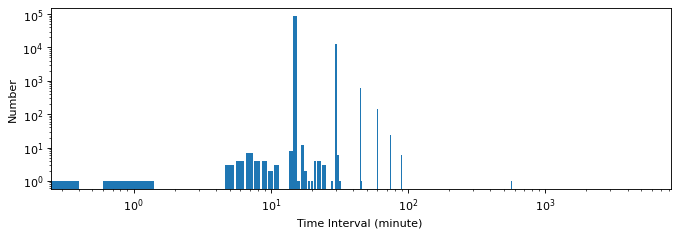

In [4]:
date_list = sorted(list(datetime2images.keys()))

year, month, day, hour, minute = int(date_list[0][0:4]), int(date_list[0][4:6]), int(date_list[0][6:8]), int(date_list[0][8:10]), int(date_list[0][10:12])
start_date = previous_date = datetime(year, month, day, hour, minute)

time_diff = defaultdict(int)
for d in date_list:
    if len(datetime2images[d]) == 4: # valid image
        year, month, day, hour, minute = int(d[0:4]), int(d[4:6]), int(d[6:8]), int(d[8:10]), int(d[10:12])
        _d = datetime(year, month, day, hour, minute)
        delta_minute = (_d - previous_date).total_seconds() / 60
        time_diff[(delta_minute)] += 1
        previous_date = _d
        end_date = _d
            
x = sorted(list(time_diff.keys()))
y = [time_diff[_x] for _x in x]

argmax_interval = x[np.argmax(y)]
print("%d" % (int(time_diff[argmax_interval] / len(valid_datetime) * 100)) + "% images have ", argmax_interval, " minute time interval")
# print(x)

plt.figure(figsize=(10,3), dpi=80)
plt.bar(x,y)
plt.ylabel("Number")
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Time Interval (minute) ")
# plt.xticks(np.arange(min(x), max(x)+1, 100.0))
plt.show()
plt.close()

3. 6시간 길이의 비디오를 구성하기 위한 적절한 이미지 개수 판단

In [5]:
video_length = 6 # hour
imgcnt2videos = defaultdict(list)

48% videos have 22 length.


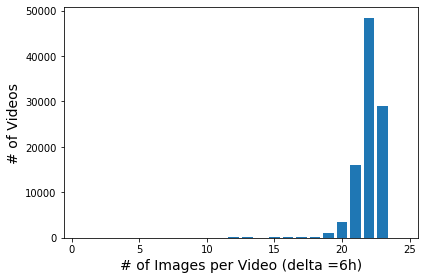

In [6]:
num_videos = 0
for i, d_i in enumerate(valid_datetime):
    year, month, day, hour, minute = int(d_i[0:4]), int(d_i[4:6]), int(d_i[6:8]), int(d_i[8:10]), int(d_i[10:12])
    _d_i = datetime(year, month, day, hour, minute)
    cnt = 1
    for j in range(i+1, len(valid_datetime)):
        d_j = valid_datetime[j]
        year, month, day, hour, minute = int(d_j[0:4]), int(d_j[4:6]), int(d_j[6:8]), int(d_j[8:10]), int(d_j[10:12])
        _d_j = datetime(year, month, day, hour, minute) 
        time_delta = (_d_j - _d_i).total_seconds() / 60 / 60
        if time_delta > video_length:
            break
        else:
            cnt += 1
    imgcnt2videos[cnt].append(d_i)
    num_videos += 1
    
max_cnt = max(imgcnt2videos.keys())
x = list(range(1, max_cnt+1))
y = [len(imgcnt2videos[_x]) for _x in x]
max_idx = np.argmax(y)
argmax_num = x[max_idx]
print("%d" % (int(y[max_idx] / num_videos * 100)) + "% videos have " + str(argmax_num) + " length.")

plt.bar(x, y)
plt.xlabel('# of Images per Video (delta =' + str(video_length) + 'h)', fontsize=14)
plt.ylabel('# of Videos', fontsize=14)
plt.tight_layout()
plt.show()

4. 비디오 생성 과정

In [7]:
numimage_per_video = 20
videos = defaultdict(list)

In [8]:
for i, datetime_i in enumerate(valid_datetime):
    year, month, day, hour, minute = int(datetime_i[0:4]), int(datetime_i[4:6]), int(datetime_i[6:8]), int(datetime_i[8:10]), int(datetime_i[10:12])
    t_i = datetime(year, month, day, hour, minute)
    videos[datetime_i].append(datetime_i)
    for j in range(i+1, len(valid_datetime)):
        datetime_j = valid_datetime[j]
        year, month, day, hour, minute = int(datetime_j[0:4]), int(datetime_j[4:6]), int(datetime_j[6:8]), int(datetime_j[8:10]), int(datetime_j[10:12])
        t_j = datetime(year, month, day, hour, minute)
        length = (t_j - t_i).total_seconds() / 60 / 60
        if length > video_length:
            break
        else:
            videos[datetime_i].append(datetime_j)

filtered_videos = []
for v in sorted(list(videos.keys())):
    if len(videos[v]) >= numimage_per_video:
        filtered_videos.append(videos[v])
            
print("Videos whose length >= {} is {}".format(numimage_per_video, int(len(filtered_videos) / len(videos) * 100)) + "% in all possible videos")

Videos whose length >= 20 is 97% in all possible videos
